In [1]:
import csv
from tqdm import tqdm

label_dict = {}
with open("../ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]

def search_in_ground_truth(file_id: str, label_dict: dict) -> str:
    wav_name = file_id + ".wav"
    return label_dict.get(wav_name, None)



Loading labels: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 19101/19101 [00:00<00:00, 3821023.55it/s]


In [2]:
import pandas as pd
from tqdm import tqdm

def load_physical_features_as_df():
    df = pd.read_csv("audio_features.csv", delimiter=",", encoding="utf-8")
    
    df_filtered = df[df['filename'].isin(label_dict.keys())]
    
    print(f"üìä Physical features loaded:")
    print(f"  Total rows in CSV: {len(df)}")
    print(f"  Filtered rows: {len(df_filtered)}")
    print(f"  Features: {list(df_filtered.columns)}")
    
    return df_filtered

physical_features_df = load_physical_features_as_df()

üìä Physical features loaded:
  Total rows in CSV: 28652
  Filtered rows: 19101
  Features: ['filename', 'split', 'duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc_8_mean', 'mfcc_8_std', 'mfcc_9_mean', 'mfcc_9_std', 'mfcc_10_mean', 'mfcc_10_std', 'mfcc_11_mean', 'mfcc_11_std', 'mfcc_12_mean', 'mfcc_12_std', 'chroma_0_mean', 'chroma_0_std', 'chroma_1_mean', 'chroma_1_std', 'chroma_2_mean', 'chroma_2_std', 'chroma_3_mean', 'chroma_3_std', 'chroma_4_mean', 'chroma_4_std', 'chroma_5_mean', 'chroma_5_std', 'chroma_6_mean', 'chroma_6_std', 'chroma_7_mean', 'chroma_7_std', 'chroma_8_mean', 'chroma_8_std', 'chroma_9_mean', 'chroma_9_std', 'chroma_10_mean', 'chroma_10_std', 'chroma_11_mean', 'chroma_11_std', 'spectral_contrast_0_mean', 'spectral_contrast_0_std', 'spectral_contrast_1_mean', 'spectr

In [3]:
physical_features_df.shape

(19101, 77)

In [4]:
from concurrent.futures import ThreadPoolExecutor
import glob
import os
import numpy as np

def load_single_acoustic_embedding(npy_file):
    basename = os.path.splitext(os.path.basename(npy_file))[0]  
    embedding = np.load(npy_file)
    return basename, embedding

def load_acoustic_embeddings(embedding_dir: str):
    npy_files = glob.glob(os.path.join(embedding_dir, "*.npy"))

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(load_single_acoustic_embedding, npy_files),
                            total=len(npy_files),
                            desc="Loading acoustic embeddings"))

    embedding_dict = dict(results)
    print(f"‚úÖ Loaded {len(embedding_dict)} embeddings.")
    print(f"üß™ Sample shape: {next(iter(embedding_dict.values())).shape}")
    return embedding_dict

In [5]:
embedding_dir = "./embeddings_lhl/"
val_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "devel_files"))
train_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "train_files"))
test_embeddings_dict = load_acoustic_embeddings(os.path.join(embedding_dir, "test_files"))

Loading acoustic embeddings: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9596/9596 [00:01<00:00, 6288.34it/s]


‚úÖ Loaded 9596 embeddings.
üß™ Sample shape: (3072,)


Loading acoustic embeddings: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9505/9505 [00:01<00:00, 6387.38it/s]


‚úÖ Loaded 9505 embeddings.
üß™ Sample shape: (3072,)


Loading acoustic embeddings: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9551/9551 [00:01<00:00, 6018.16it/s]

‚úÖ Loaded 9551 embeddings.
üß™ Sample shape: (3072,)


In [6]:
def create_multimodal_features_with_merge(embeddings_dict, physical_features_df):    
    acoustic_data = []
    for file_id, embedding in embeddings_dict.items():
        filename = f"{file_id}.wav"
        
        acoustic_data.append({
            'filename': filename,
            'file_id': file_id,
            'embedding_idx': 0,
            'acoustic_features': embedding
        })
    
    acoustic_df = pd.DataFrame(acoustic_data)
    
    numeric_columns = physical_features_df.select_dtypes(include=[np.number]).columns.tolist()
    
    columns_to_remove = ['split'] 
    for col in columns_to_remove:
        if col in numeric_columns:
            numeric_columns.remove(col)
            print(f"‚ö†Ô∏è  Removed column: {col}")
    
    physical_subset = physical_features_df[['filename'] + numeric_columns].copy()
    
    merged_df = acoustic_df.merge(physical_subset, on='filename', how='left')
    
    merged_df[numeric_columns] = merged_df[numeric_columns].fillna(0)
    
    combined_features = {}
    
    for _, row in tqdm(merged_df.iterrows(), total=len(merged_df), desc="Creating combined features"):
        file_id = row['file_id']
        embedding_idx = row['embedding_idx']
        
        acoustic = row['acoustic_features']
        physical = row[numeric_columns].values.astype(np.float32)
        combined = np.concatenate([acoustic, physical])
        
        if file_id not in combined_features:
            combined_features[file_id] = []
        combined_features[file_id].append(combined)
    
    for file_id in combined_features:
        if len(combined_features[file_id]) == 1:
            combined_features[file_id] = combined_features[file_id][0]
    
    print(f"üìä Multimodal features created:")
    print(f"  Files: {len(combined_features)}")
    print(f"  Acoustic features: {acoustic.shape[0]}")
    print(f"  Physical features: {len(numeric_columns)}")
    print(f"  Combined dimension: {combined.shape[0]}")
    print(f"  Used physical columns: {numeric_columns[:10]}...")  
    return combined_features

train_multimodal = create_multimodal_features_with_merge(train_embeddings_dict, physical_features_df)
val_multimodal = create_multimodal_features_with_merge(val_embeddings_dict, physical_features_df)
test_multimodal = create_multimodal_features_with_merge(test_embeddings_dict, physical_features_df)

Creating combined features: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9505/9505 [00:02<00:00, 4341.01it/s]


üìä Multimodal features created:
  Files: 9505
  Acoustic features: 3072
  Physical features: 75
  Combined dimension: 3147
  Used physical columns: ['duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean']...


Creating combined features: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9596/9596 [00:02<00:00, 4340.00it/s]


üìä Multimodal features created:
  Files: 9596
  Acoustic features: 3072
  Physical features: 75
  Combined dimension: 3147
  Used physical columns: ['duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean']...


Creating combined features: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9551/9551 [00:02<00:00, 4453.98it/s]

üìä Multimodal features created:
  Files: 9551
  Acoustic features: 3072
  Physical features: 75
  Combined dimension: 3147
  Used physical columns: ['duration', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_4_mean']...


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ContrastiveEmbeddingExtractor(nn.Module):
    def __init__(self, input_dim=3072, projection_dim=256, hidden_dim=512):
        super(ContrastiveEmbeddingExtractor, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(hidden_dim)
        )
        
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, projection_dim),
            L2Norm(dim=1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )
    
    def forward(self, x, return_features=False):
        features = self.encoder(x)
        
        logits = self.classifier(features)
        
        if return_features:
            projections = self.projection_head(features)
            return logits.squeeze(), projections, features
        else:
            return logits.squeeze()

class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super(L2Norm, self).__init__()
        self.dim = dim
    
    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim)
    
class SupervisedContrastiveLoss(nn.Module):

    def __init__(self, temperature=0.1, minority_weight=2.0):
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.minority_weight = minority_weight
        
    def forward(self, projections, labels):
        device = projections.device
        batch_size = projections.shape[0]
        
        similarity_matrix = torch.matmul(projections, projections.T) / self.temperature
        
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(device)
        
        mask = mask - torch.eye(batch_size).to(device)
        
        exp_sim = torch.exp(similarity_matrix)
        
        pos_sim = exp_sim * mask
        
        neg_mask = torch.ones_like(mask) - torch.eye(batch_size).to(device)
        all_sim = exp_sim * neg_mask
        
        losses = []
        for i in range(batch_size):
            if mask[i].sum() > 0:  
                pos_sum = pos_sim[i].sum()
                neg_sum = all_sim[i].sum()
                
                if neg_sum > 0:
                    loss_i = -torch.log(pos_sum / neg_sum)
                    
                    if labels[i] == 1:  
                        loss_i = loss_i * self.minority_weight
                    
                    losses.append(loss_i)
        
        if len(losses) > 0:
            return torch.stack(losses).mean()
        else:
            return torch.tensor(0.0).to(device)

class CombinedLoss(nn.Module):
    def __init__(self, classification_loss, contrastive_loss, alpha=0.3):
        super(CombinedLoss, self).__init__()
        self.classification_loss = classification_loss
        self.contrastive_loss = contrastive_loss
        self.alpha = alpha  
        
    def forward(self, logits, projections, labels):
        cls_loss = self.classification_loss(logits, labels.float())
        
        cont_loss = self.contrastive_loss(projections, labels)
        
        total_loss = (1 - self.alpha) * cls_loss + self.alpha * cont_loss
        
        return total_loss, cls_loss, cont_loss

In [8]:
from torch.utils.data import Dataset
import torch
import random

class ColdDetectionDataset(Dataset):
    def __init__(self,
                 embedding_dict: dict,
                 label_dict: dict,
                 label_ratio = 2,
                ):
        
        self.data_map = {} 
        self.all_samples = []
        
        for file_id, emb in embedding_dict.items():
            label_key = f"{file_id}.wav"
            if label_key not in label_dict:
                continue
                
            raw_label = label_dict[label_key]
            lab = 1 if raw_label == "C" else 0
            
            sample = (
                file_id,
                torch.tensor(emb, dtype=torch.float32),
                torch.tensor(lab, dtype=torch.long),
            ) 
            self.all_samples.append(sample)
        
        self.create_balanced_cold_dataset( label_ratio)

        
    
    def create_balanced_cold_dataset(self, label_ratio):
        samples_by_label = {0: [], 1: []}
        for sample in self.all_samples:
            label = sample[2].item()
            samples_by_label[label].append(sample)
                        
        num_healthy_samples = min(len(samples_by_label[1])*label_ratio, len(samples_by_label[0]))     
        self.balanced_samples = []
        
        for sample in samples_by_label[1]:
            self.balanced_samples.append(sample)
        
        healthy_samples = random.sample(samples_by_label[0], num_healthy_samples)
        self.balanced_samples.extend(healthy_samples)

        random.shuffle(self.balanced_samples)
        self.epoch_samples = self.balanced_samples.copy()

    def __getitem__(self, idx):
        sample = self.epoch_samples[idx]
        
        if len(sample) == 3:
            file_id, embedding, label = sample
            return embedding, label
        else:
            raise ValueError(f"Unexpected sample format with {len(sample)} elements")
        
    
    def __len__(self):
        return len(self.epoch_samples)
    
    
    def refresh_epoch_samples_balanced(self, label_ratio):
        self.create_balanced_cold_dataset(label_ratio)
    
    def get_statistics(self):
        stats = {
            'total_samples': len(self.all_samples),
            'epoch_samples': len(self.epoch_samples),
        }
        
        return stats

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ContrastiveEmbeddingExtractor(input_dim=3147, projection_dim=1024,hidden_dim=512).to(device)
# model = MultiScaleConvContrastiveExtractor(input_dim=1536, projection_dim=256, hidden_dim=512).to(device)
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3.2)) # Adjust weights for class imbalance
# criterion = SimpleFocalLoss(alpha=0.25, gamma=0.25)
classification_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(4.0).to(device))
contrastive_loss = SupervisedContrastiveLoss(temperature=0.05, minority_weight=2.0)
criterion = CombinedLoss(
    classification_loss=classification_loss,
    contrastive_loss=contrastive_loss,
    alpha=0.3 
)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-6, betas=(0.85, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

threshold = 0.5  # Threshold for binary classification
# ‚úÖ Training Loop
num_epochs = 100

In [10]:
import time
from sklearn.metrics import accuracy_score, f1_score, recall_score
from torch.utils.data import DataLoader

best_val_uar = 0.0  # Êîπ‰∏∫UAR
patience = 30
early_stop_counter = 0

train_losses = []
val_losses = []
train_uar_scores = []  # Êîπ‰∏∫UAR
val_uar_scores = []    # Êîπ‰∏∫UAR

train_dataset = ColdDetectionDataset(
    train_multimodal, 
    label_dict,
    label_ratio=5,
)
val_dataset = ColdDetectionDataset(
    val_multimodal, 
    label_dict,
    label_ratio=15,
)
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("üöÄ Start CL...\n")

for epoch in range(num_epochs):
    model.train()
    
    total_loss = 0.0
    total_cls_loss = 0.0
    total_cont_loss = 0.0
    all_preds, all_labels = [], []
    
    print(f'\n{"="*80}')
    print(f'Epoch [{epoch+1}/{num_epochs}] - Contrastive Embedding Learning')
    print(f'{"="*80}\n')
    
    if epoch > 0:
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch_X, batch_y in progress_bar:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        logits, projections, features = model(
            batch_X, return_features=True
        )
        
        loss, cls_loss, cont_loss = criterion(
            logits, projections, batch_y
        )
        
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            preds = (torch.sigmoid(logits) > threshold).long()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
        
        total_loss += loss.item()
        total_cls_loss += cls_loss.item()
        total_cont_loss += cont_loss.item()
        
        progress_bar.set_postfix({
            'Total': f'{loss.item():.4f}',
            'Cls': f'{cls_loss.item():.4f}',
            'Cont': f'{cont_loss.item():.4f}'
        })
    
    avg_loss = total_loss / len(train_loader)
    avg_cls_loss = total_cls_loss / len(train_loader)
    avg_cont_loss = total_cont_loss / len(train_loader)
    
    train_acc = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, zero_division=0)
    train_uar = recall_score(all_labels, all_preds, average='macro', zero_division=0)  # Ê∑ªÂä†UAR
    
    model.eval()
    val_preds, val_labels = [], []
    total_val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(val_loader, desc="Validating"):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            logits, projections, features = model(
                batch_X, return_features=True
            )
            
            val_loss, _, _ = criterion(logits, projections, batch_y)
            total_val_loss += val_loss.item()
            
            preds = (torch.sigmoid(logits) > threshold).long()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, zero_division=0)
    val_uar = recall_score(val_labels, val_preds, average='macro', zero_division=0)  # Ê∑ªÂä†UAR
    
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_uar_scores.append(train_uar)  # Êîπ‰∏∫UAR
    val_uar_scores.append(val_uar)      # Êîπ‰∏∫UAR
    
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    print(f"\nEpoch [{epoch+1}] Summary:")
    print(f"  üéØ Learning Rate: {current_lr:.2e}")
    print(f"  üìà Training   - Loss: {avg_loss:.4f} (Cls: {avg_cls_loss:.4f}, Cont: {avg_cont_loss:.4f})")
    print(f"                 Acc: {train_acc:.4f}, F1: {train_f1:.4f}, UAR: {train_uar:.4f}")  # Ê∑ªÂä†UARÊòæÁ§∫
    print(f"  üìä Validation - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, UAR: {val_uar:.4f}")  # Ê∑ªÂä†UARÊòæÁ§∫
    
    # ËØ¶ÁªÜÁöÑÁ±ªÂà´Âè¨ÂõûÁéá
    if len(set(val_labels)) > 1 and len(set(val_preds)) > 1:
        class_recalls = recall_score(val_labels, val_preds, average=None, zero_division=0)
        print(f"  üéØ Class Recalls - Healthy: {class_recalls[0]:.4f}, Cold: {class_recalls[1]:.4f}")
    
    # Êîπ‰∏∫Âü∫‰∫éUARÁöÑÊ®°Âûã‰øùÂ≠ò
    if val_uar > best_val_uar:
        best_val_uar = val_uar
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_contrastive_fusion_concat.pth")
        print(f"üåü New best UAR: {best_val_uar:.4f}, saving model...")
    else:
        early_stop_counter += 1
        print(f"‚è≥ No improvement for {early_stop_counter}/{patience} epochs")
        if early_stop_counter >= patience:
            print(f"‚ùå Early stopping after {patience} epochs without improvement")
            break

print(f"\nüéâ Finish Training! Best UAR: {best_val_uar:.4f}")
torch.save(model.state_dict(), "last_contrastive_fusion_concat.pth")

# ‰øùÂ≠òËÆ≠ÁªÉÂéÜÂè≤
training_history = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_uar_scores': train_uar_scores,
    'val_uar_scores': val_uar_scores,
    'best_val_uar': best_val_uar,
    'total_epochs': epoch + 1,
    'early_stopped': early_stop_counter >= patience
}

torch.save(training_history, 'contrastive_training_history.pth')
print(f"üíæ Training history saved to 'contrastive_training_history.pth'")

üöÄ Start CL...


Epoch [1/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.58it/s]



Epoch [1] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9541 (Cls: 1.0394, Cont: 0.7550)
                 Acc: 0.6040, F1: 0.2445, UAR: 0.5162
  üìä Validation - Loss: 0.7784, Acc: 0.8946, F1: 0.0000, UAR: 0.5000
üåü New best UAR: 0.5000, saving model...

Epoch [2/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.57it/s]



Epoch [2] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9515 (Cls: 1.0324, Cont: 0.7627)
                 Acc: 0.7823, F1: 0.1134, UAR: 0.5028
  üìä Validation - Loss: 0.7779, Acc: 0.8840, F1: 0.0364, UAR: 0.5032
  üéØ Class Recalls - Healthy: 0.9857, Cold: 0.0208
üåü New best UAR: 0.5032, saving model...

Epoch [3/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.84it/s]



Epoch [3] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9453 (Cls: 1.0271, Cont: 0.7543)
                 Acc: 0.7856, F1: 0.1680, UAR: 0.5233
  üìä Validation - Loss: 0.7663, Acc: 0.8850, F1: 0.0417, UAR: 0.5051
  üéØ Class Recalls - Healthy: 0.9864, Cold: 0.0237
üåü New best UAR: 0.5051, saving model...

Epoch [4/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.42it/s]



Epoch [4] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9397 (Cls: 1.0214, Cont: 0.7490)
                 Acc: 0.7844, F1: 0.1835, UAR: 0.5288
  üìä Validation - Loss: 0.7626, Acc: 0.8771, F1: 0.0515, UAR: 0.5042
  üéØ Class Recalls - Healthy: 0.9767, Cold: 0.0317
‚è≥ No improvement for 1/30 epochs

Epoch [5/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.23it/s]



Epoch [5] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9375 (Cls: 1.0219, Cont: 0.7405)
                 Acc: 0.7608, F1: 0.1841, UAR: 0.5212
  üìä Validation - Loss: 0.7655, Acc: 0.8540, F1: 0.1754, UAR: 0.5423
  üéØ Class Recalls - Healthy: 0.9372, Cold: 0.1474
üåü New best UAR: 0.5423, saving model...

Epoch [6/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.18it/s]



Epoch [6] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9338 (Cls: 1.0169, Cont: 0.7399)
                 Acc: 0.7809, F1: 0.1925, UAR: 0.5312
  üìä Validation - Loss: 0.7588, Acc: 0.8442, F1: 0.2052, UAR: 0.5560
  üéØ Class Recalls - Healthy: 0.9211, Cold: 0.1909
üåü New best UAR: 0.5560, saving model...

Epoch [7/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 15.48it/s]



Epoch [7] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9301 (Cls: 1.0144, Cont: 0.7335)
                 Acc: 0.7399, F1: 0.2535, UAR: 0.5499
  üìä Validation - Loss: 0.7603, Acc: 0.8118, F1: 0.2431, UAR: 0.5802
  üéØ Class Recalls - Healthy: 0.8736, Cold: 0.2868
üåü New best UAR: 0.5802, saving model...

Epoch [8/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.68it/s]



Epoch [8] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9280 (Cls: 1.0128, Cont: 0.7301)
                 Acc: 0.7521, F1: 0.2473, UAR: 0.5490
  üìä Validation - Loss: 0.7487, Acc: 0.8709, F1: 0.1554, UAR: 0.5365
  üéØ Class Recalls - Healthy: 0.9602, Cold: 0.1128
‚è≥ No improvement for 1/30 epochs

Epoch [9/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.68it/s]



Epoch [9] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9276 (Cls: 1.0122, Cont: 0.7302)
                 Acc: 0.7631, F1: 0.2402, UAR: 0.5477
  üìä Validation - Loss: 0.7522, Acc: 0.8300, F1: 0.2417, UAR: 0.5773
  üéØ Class Recalls - Healthy: 0.8975, Cold: 0.2572
‚è≥ No improvement for 2/30 epochs

Epoch [10/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 18.03it/s]



Epoch [10] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9234 (Cls: 1.0102, Cont: 0.7208)
                 Acc: 0.7533, F1: 0.2362, UAR: 0.5435
  üìä Validation - Loss: 0.7564, Acc: 0.8033, F1: 0.2665, UAR: 0.5986
  üéØ Class Recalls - Healthy: 0.8579, Cold: 0.3393
üåü New best UAR: 0.5986, saving model...

Epoch [11/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 15.08it/s]



Epoch [11] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9172 (Cls: 1.0070, Cont: 0.7075)
                 Acc: 0.7622, F1: 0.2495, UAR: 0.5522
  üìä Validation - Loss: 0.7558, Acc: 0.7679, F1: 0.2729, UAR: 0.6116
  üéØ Class Recalls - Healthy: 0.8097, Cold: 0.4135
üåü New best UAR: 0.6116, saving model...

Epoch [12/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 15.97it/s]



Epoch [12] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9209 (Cls: 1.0095, Cont: 0.7143)
                 Acc: 0.7405, F1: 0.2465, UAR: 0.5462
  üìä Validation - Loss: 0.7520, Acc: 0.8166, F1: 0.2697, UAR: 0.5982
  üéØ Class Recalls - Healthy: 0.8749, Cold: 0.3215
‚è≥ No improvement for 1/30 epochs

Epoch [13/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.73it/s]



Epoch [13] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9118 (Cls: 1.0021, Cont: 0.7012)
                 Acc: 0.7601, F1: 0.2676, UAR: 0.5612
  üìä Validation - Loss: 0.7608, Acc: 0.6974, F1: 0.2733, UAR: 0.6280
  üéØ Class Recalls - Healthy: 0.7159, Cold: 0.5401
üåü New best UAR: 0.6280, saving model...

Epoch [14/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.42it/s]



Epoch [14] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.9064 (Cls: 1.0017, Cont: 0.6839)
                 Acc: 0.7515, F1: 0.2799, UAR: 0.5668
  üìä Validation - Loss: 0.7452, Acc: 0.8201, F1: 0.2711, UAR: 0.5984
  üéØ Class Recalls - Healthy: 0.8793, Cold: 0.3175
‚è≥ No improvement for 1/30 epochs

Epoch [15/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 15.71it/s]



Epoch [15] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8990 (Cls: 0.9937, Cont: 0.6781)
                 Acc: 0.7471, F1: 0.2777, UAR: 0.5649
  üìä Validation - Loss: 0.7374, Acc: 0.8585, F1: 0.2456, UAR: 0.5762
  üéØ Class Recalls - Healthy: 0.9338, Cold: 0.2186
‚è≥ No improvement for 2/30 epochs

Epoch [16/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.17it/s]



Epoch [16] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8931 (Cls: 0.9962, Cont: 0.6524)
                 Acc: 0.7522, F1: 0.2598, UAR: 0.5557
  üìä Validation - Loss: 0.7332, Acc: 0.8518, F1: 0.2539, UAR: 0.5817
  üéØ Class Recalls - Healthy: 0.9239, Cold: 0.2394
‚è≥ No improvement for 3/30 epochs

Epoch [17/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 15.97it/s]



Epoch [17] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8835 (Cls: 0.9912, Cont: 0.6321)
                 Acc: 0.7486, F1: 0.2790, UAR: 0.5659
  üìä Validation - Loss: 0.7526, Acc: 0.7023, F1: 0.2765, UAR: 0.6307
  üéØ Class Recalls - Healthy: 0.7214, Cold: 0.5401
üåü New best UAR: 0.6307, saving model...

Epoch [18/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 18.71it/s]



Epoch [18] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8743 (Cls: 0.9880, Cont: 0.6090)
                 Acc: 0.7509, F1: 0.2850, UAR: 0.5697
  üìä Validation - Loss: 0.7416, Acc: 0.7414, F1: 0.2831, UAR: 0.6281
  üéØ Class Recalls - Healthy: 0.7716, Cold: 0.4847
‚è≥ No improvement for 1/30 epochs

Epoch [19/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:03<00:00, 18.79it/s]



Epoch [19] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8673 (Cls: 0.9841, Cont: 0.5947)
                 Acc: 0.7423, F1: 0.2795, UAR: 0.5654
  üìä Validation - Loss: 0.7355, Acc: 0.7854, F1: 0.2863, UAR: 0.6192
  üéØ Class Recalls - Healthy: 0.8298, Cold: 0.4085
‚è≥ No improvement for 2/30 epochs

Epoch [20/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.10it/s]



Epoch [20] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8582 (Cls: 0.9807, Cont: 0.5725)
                 Acc: 0.7364, F1: 0.2778, UAR: 0.5635
  üìä Validation - Loss: 0.7249, Acc: 0.8415, F1: 0.2740, UAR: 0.5955
  üéØ Class Recalls - Healthy: 0.9072, Cold: 0.2839
‚è≥ No improvement for 3/30 epochs

Epoch [21/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.57it/s]



Epoch [21] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8523 (Cls: 0.9743, Cont: 0.5674)
                 Acc: 0.7460, F1: 0.3048, UAR: 0.5812
  üìä Validation - Loss: 0.7141, Acc: 0.8650, F1: 0.2510, UAR: 0.5781
  üéØ Class Recalls - Healthy: 0.9416, Cold: 0.2146
‚è≥ No improvement for 4/30 epochs

Epoch [22/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:03<00:00, 20.17it/s]



Epoch [22] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8432 (Cls: 0.9678, Cont: 0.5525)
                 Acc: 0.7637, F1: 0.3203, UAR: 0.5919
  üìä Validation - Loss: 0.7340, Acc: 0.7303, F1: 0.2878, UAR: 0.6363
  üéØ Class Recalls - Healthy: 0.7554, Cold: 0.5173
üåü New best UAR: 0.6363, saving model...

Epoch [23/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.15it/s]



Epoch [23] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8347 (Cls: 0.9606, Cont: 0.5408)
                 Acc: 0.7524, F1: 0.3263, UAR: 0.5954
  üìä Validation - Loss: 0.7165, Acc: 0.8457, F1: 0.2636, UAR: 0.5883
  üéØ Class Recalls - Healthy: 0.9144, Cold: 0.2621
‚è≥ No improvement for 1/30 epochs

Epoch [24/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 18.20it/s]



Epoch [24] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8289 (Cls: 0.9577, Cont: 0.5286)
                 Acc: 0.7526, F1: 0.3156, UAR: 0.5885
  üìä Validation - Loss: 0.7187, Acc: 0.7992, F1: 0.2785, UAR: 0.6090
  üéØ Class Recalls - Healthy: 0.8500, Cold: 0.3680
‚è≥ No improvement for 2/30 epochs

Epoch [25/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 18.00it/s]



Epoch [25] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8245 (Cls: 0.9490, Cont: 0.5338)
                 Acc: 0.7390, F1: 0.3438, UAR: 0.6075
  üìä Validation - Loss: 0.7102, Acc: 0.8217, F1: 0.2771, UAR: 0.6023
  üéØ Class Recalls - Healthy: 0.8803, Cold: 0.3244
‚è≥ No improvement for 3/30 epochs

Epoch [26/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.31it/s]



Epoch [26] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8143 (Cls: 0.9443, Cont: 0.5110)
                 Acc: 0.7615, F1: 0.3520, UAR: 0.6124
  üìä Validation - Loss: 0.7283, Acc: 0.7044, F1: 0.2888, UAR: 0.6450
  üéØ Class Recalls - Healthy: 0.7202, Cold: 0.5697
üåü New best UAR: 0.6450, saving model...

Epoch [27/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.40it/s]



Epoch [27] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.8065 (Cls: 0.9403, Cont: 0.4942)
                 Acc: 0.7448, F1: 0.3524, UAR: 0.6135
  üìä Validation - Loss: 0.7063, Acc: 0.8324, F1: 0.2631, UAR: 0.5905
  üéØ Class Recalls - Healthy: 0.8970, Cold: 0.2839
‚è≥ No improvement for 1/30 epochs

Epoch [28/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 18.72it/s]



Epoch [28] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.7987 (Cls: 0.9316, Cont: 0.4884)
                 Acc: 0.7582, F1: 0.3733, UAR: 0.6277
  üìä Validation - Loss: 0.7021, Acc: 0.8595, F1: 0.2544, UAR: 0.5807
  üéØ Class Recalls - Healthy: 0.9340, Cold: 0.2275
‚è≥ No improvement for 2/30 epochs

Epoch [29/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.81it/s]



Epoch [29] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.7951 (Cls: 0.9237, Cont: 0.4948)
                 Acc: 0.7679, F1: 0.3624, UAR: 0.6191
  üìä Validation - Loss: 0.7185, Acc: 0.7476, F1: 0.2902, UAR: 0.6338
  üéØ Class Recalls - Healthy: 0.7780, Cold: 0.4896
‚è≥ No improvement for 3/30 epochs

Epoch [30/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.70it/s]



Epoch [30] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.7835 (Cls: 0.9103, Cont: 0.4879)
                 Acc: 0.7564, F1: 0.3851, UAR: 0.6369
  üìä Validation - Loss: 0.7027, Acc: 0.8253, F1: 0.2776, UAR: 0.6018
  üéØ Class Recalls - Healthy: 0.8850, Cold: 0.3185
‚è≥ No improvement for 4/30 epochs

Epoch [31/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.43it/s]



Epoch [31] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.7733 (Cls: 0.9011, Cont: 0.4751)
                 Acc: 0.7649, F1: 0.4098, UAR: 0.6548
  üìä Validation - Loss: 0.6950, Acc: 0.8516, F1: 0.2583, UAR: 0.5842
  üéØ Class Recalls - Healthy: 0.9230, Cold: 0.2453
‚è≥ No improvement for 5/30 epochs

Epoch [32/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:03<00:00, 18.97it/s]



Epoch [32] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.7613 (Cls: 0.8849, Cont: 0.4730)
                 Acc: 0.7746, F1: 0.4241, UAR: 0.6639
  üìä Validation - Loss: 0.7019, Acc: 0.8107, F1: 0.2861, UAR: 0.6119
  üéØ Class Recalls - Healthy: 0.8637, Cold: 0.3600
‚è≥ No improvement for 6/30 epochs

Epoch [33/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.18it/s]



Epoch [33] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.7447 (Cls: 0.8670, Cont: 0.4593)
                 Acc: 0.7825, F1: 0.4500, UAR: 0.6831
  üìä Validation - Loss: 0.7008, Acc: 0.8062, F1: 0.2791, UAR: 0.6076
  üéØ Class Recalls - Healthy: 0.8592, Cold: 0.3561
‚è≥ No improvement for 7/30 epochs

Epoch [34/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.98it/s]



Epoch [34] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.7265 (Cls: 0.8482, Cont: 0.4425)
                 Acc: 0.7789, F1: 0.4479, UAR: 0.6826
  üìä Validation - Loss: 0.7126, Acc: 0.7925, F1: 0.2736, UAR: 0.6065
  üéØ Class Recalls - Healthy: 0.8422, Cold: 0.3709
‚è≥ No improvement for 8/30 epochs

Epoch [35/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 15.73it/s]



Epoch [35] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.7177 (Cls: 0.8305, Cont: 0.4546)
                 Acc: 0.7861, F1: 0.4819, UAR: 0.7104
  üìä Validation - Loss: 0.6905, Acc: 0.8612, F1: 0.2559, UAR: 0.5812
  üéØ Class Recalls - Healthy: 0.9359, Cold: 0.2265
‚è≥ No improvement for 9/30 epochs

Epoch [36/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.24it/s]



Epoch [36] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.7041 (Cls: 0.8178, Cont: 0.4389)
                 Acc: 0.7878, F1: 0.4852, UAR: 0.7127
  üìä Validation - Loss: 0.6993, Acc: 0.8203, F1: 0.2676, UAR: 0.5959
  üéØ Class Recalls - Healthy: 0.8803, Cold: 0.3116
‚è≥ No improvement for 10/30 epochs

Epoch [37/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.68it/s]



Epoch [37] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.6923 (Cls: 0.8007, Cont: 0.4395)
                 Acc: 0.7811, F1: 0.4834, UAR: 0.7144
  üìä Validation - Loss: 0.6922, Acc: 0.8281, F1: 0.2820, UAR: 0.6042
  üéØ Class Recalls - Healthy: 0.8878, Cold: 0.3205
‚è≥ No improvement for 11/30 epochs

Epoch [38/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.86it/s]



Epoch [38] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.6736 (Cls: 0.7742, Cont: 0.4388)
                 Acc: 0.7964, F1: 0.5117, UAR: 0.7339
  üìä Validation - Loss: 0.7086, Acc: 0.8513, F1: 0.2641, UAR: 0.5875
  üéØ Class Recalls - Healthy: 0.9217, Cold: 0.2532
‚è≥ No improvement for 12/30 epochs

Epoch [39/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.68it/s]



Epoch [39] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.6598 (Cls: 0.7582, Cont: 0.4303)
                 Acc: 0.7983, F1: 0.5251, UAR: 0.7466
  üìä Validation - Loss: 0.7117, Acc: 0.8639, F1: 0.2511, UAR: 0.5784
  üéØ Class Recalls - Healthy: 0.9401, Cold: 0.2166
‚è≥ No improvement for 13/30 epochs

Epoch [40/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 18.25it/s]



Epoch [40] Summary:
  üéØ Learning Rate: 1.00e-05
  üìà Training   - Loss: 0.6493 (Cls: 0.7485, Cont: 0.4177)
                 Acc: 0.8002, F1: 0.5243, UAR: 0.7444
  üìä Validation - Loss: 0.7304, Acc: 0.7196, F1: 0.2460, UAR: 0.5937
  üéØ Class Recalls - Healthy: 0.7532, Cold: 0.4342
‚è≥ No improvement for 14/30 epochs

Epoch [41/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.73it/s]



Epoch [41] Summary:
  üéØ Learning Rate: 5.00e-06
  üìà Training   - Loss: 0.6395 (Cls: 0.7358, Cont: 0.4149)
                 Acc: 0.7955, F1: 0.5248, UAR: 0.7482
  üìä Validation - Loss: 0.7113, Acc: 0.8002, F1: 0.2686, UAR: 0.6008
  üéØ Class Recalls - Healthy: 0.8535, Cold: 0.3482
‚è≥ No improvement for 15/30 epochs

Epoch [42/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.40it/s]



Epoch [42] Summary:
  üéØ Learning Rate: 5.00e-06
  üìà Training   - Loss: 0.6141 (Cls: 0.7112, Cont: 0.3875)
                 Acc: 0.8086, F1: 0.5486, UAR: 0.7643
  üìä Validation - Loss: 0.7114, Acc: 0.8380, F1: 0.2811, UAR: 0.6010
  üéØ Class Recalls - Healthy: 0.9012, Cold: 0.3007
‚è≥ No improvement for 16/30 epochs

Epoch [43/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.17it/s]



Epoch [43] Summary:
  üéØ Learning Rate: 5.00e-06
  üìà Training   - Loss: 0.6027 (Cls: 0.6953, Cont: 0.3867)
                 Acc: 0.8167, F1: 0.5678, UAR: 0.7791
  üìä Validation - Loss: 0.7188, Acc: 0.8128, F1: 0.2787, UAR: 0.6057
  üéØ Class Recalls - Healthy: 0.8681, Cold: 0.3432
‚è≥ No improvement for 17/30 epochs

Epoch [44/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.35it/s]



Epoch [44] Summary:
  üéØ Learning Rate: 5.00e-06
  üìà Training   - Loss: 0.6035 (Cls: 0.6988, Cont: 0.3810)
                 Acc: 0.8117, F1: 0.5527, UAR: 0.7662
  üìä Validation - Loss: 0.7276, Acc: 0.8355, F1: 0.2686, UAR: 0.5935
  üéØ Class Recalls - Healthy: 0.9001, Cold: 0.2868
‚è≥ No improvement for 18/30 epochs

Epoch [45/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.25it/s]



Epoch [45] Summary:
  üéØ Learning Rate: 5.00e-06
  üìà Training   - Loss: 0.5966 (Cls: 0.6896, Cont: 0.3798)
                 Acc: 0.8216, F1: 0.5653, UAR: 0.7713
  üìä Validation - Loss: 0.7321, Acc: 0.7506, F1: 0.2538, UAR: 0.5971
  üéØ Class Recalls - Healthy: 0.7916, Cold: 0.4026
‚è≥ No improvement for 19/30 epochs

Epoch [46/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.41it/s]



Epoch [46] Summary:
  üéØ Learning Rate: 5.00e-06
  üìà Training   - Loss: 0.5979 (Cls: 0.6905, Cont: 0.3818)
                 Acc: 0.8105, F1: 0.5583, UAR: 0.7737
  üìä Validation - Loss: 0.7404, Acc: 0.7510, F1: 0.2527, UAR: 0.5960
  üéØ Class Recalls - Healthy: 0.7924, Cold: 0.3996
‚è≥ No improvement for 20/30 epochs

Epoch [47/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 18.32it/s]



Epoch [47] Summary:
  üéØ Learning Rate: 2.50e-06
  üìà Training   - Loss: 0.5868 (Cls: 0.6767, Cont: 0.3770)
                 Acc: 0.8194, F1: 0.5722, UAR: 0.7815
  üìä Validation - Loss: 0.7257, Acc: 0.8165, F1: 0.2768, UAR: 0.6034
  üéØ Class Recalls - Healthy: 0.8734, Cold: 0.3333
‚è≥ No improvement for 21/30 epochs

Epoch [48/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 15.95it/s]



Epoch [48] Summary:
  üéØ Learning Rate: 2.50e-06
  üìà Training   - Loss: 0.5783 (Cls: 0.6742, Cont: 0.3544)
                 Acc: 0.8234, F1: 0.5759, UAR: 0.7819
  üìä Validation - Loss: 0.7467, Acc: 0.7280, F1: 0.2526, UAR: 0.5993
  üéØ Class Recalls - Healthy: 0.7624, Cold: 0.4362
‚è≥ No improvement for 22/30 epochs

Epoch [49/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 15.76it/s]



Epoch [49] Summary:
  üéØ Learning Rate: 2.50e-06
  üìà Training   - Loss: 0.5705 (Cls: 0.6616, Cont: 0.3581)
                 Acc: 0.8268, F1: 0.5814, UAR: 0.7847
  üìä Validation - Loss: 0.7468, Acc: 0.7330, F1: 0.2496, UAR: 0.5955
  üéØ Class Recalls - Healthy: 0.7697, Cold: 0.4214
‚è≥ No improvement for 23/30 epochs

Epoch [50/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.11it/s]



Epoch [50] Summary:
  üéØ Learning Rate: 2.50e-06
  üìà Training   - Loss: 0.5659 (Cls: 0.6579, Cont: 0.3513)
                 Acc: 0.8254, F1: 0.5843, UAR: 0.7897
  üìä Validation - Loss: 0.7360, Acc: 0.7832, F1: 0.2598, UAR: 0.5970
  üéØ Class Recalls - Healthy: 0.8330, Cold: 0.3610
‚è≥ No improvement for 24/30 epochs

Epoch [51/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.11it/s]



Epoch [51] Summary:
  üéØ Learning Rate: 2.50e-06
  üìà Training   - Loss: 0.5658 (Cls: 0.6608, Cont: 0.3443)
                 Acc: 0.8215, F1: 0.5785, UAR: 0.7869
  üìä Validation - Loss: 0.7456, Acc: 0.7447, F1: 0.2562, UAR: 0.6003
  üéØ Class Recalls - Healthy: 0.7832, Cold: 0.4174
‚è≥ No improvement for 25/30 epochs

Epoch [52/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.56it/s]



Epoch [52] Summary:
  üéØ Learning Rate: 2.50e-06
  üìà Training   - Loss: 0.5652 (Cls: 0.6559, Cont: 0.3535)
                 Acc: 0.8234, F1: 0.5797, UAR: 0.7864
  üìä Validation - Loss: 0.7312, Acc: 0.7922, F1: 0.2653, UAR: 0.5998
  üéØ Class Recalls - Healthy: 0.8436, Cold: 0.3561
‚è≥ No improvement for 26/30 epochs

Epoch [53/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.91it/s]



Epoch [53] Summary:
  üéØ Learning Rate: 1.25e-06
  üìà Training   - Loss: 0.5649 (Cls: 0.6575, Cont: 0.3490)
                 Acc: 0.8182, F1: 0.5724, UAR: 0.7829
  üìä Validation - Loss: 0.7332, Acc: 0.7780, F1: 0.2660, UAR: 0.6032
  üéØ Class Recalls - Healthy: 0.8247, Cold: 0.3818
‚è≥ No improvement for 27/30 epochs

Epoch [54/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.72it/s]



Epoch [54] Summary:
  üéØ Learning Rate: 1.25e-06
  üìà Training   - Loss: 0.5540 (Cls: 0.6451, Cont: 0.3413)
                 Acc: 0.8285, F1: 0.5900, UAR: 0.7932
  üìä Validation - Loss: 0.7396, Acc: 0.7697, F1: 0.2633, UAR: 0.6025
  üéØ Class Recalls - Healthy: 0.8143, Cold: 0.3907
‚è≥ No improvement for 28/30 epochs

Epoch [55/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 16.72it/s]



Epoch [55] Summary:
  üéØ Learning Rate: 1.25e-06
  üìà Training   - Loss: 0.5498 (Cls: 0.6428, Cont: 0.3328)
                 Acc: 0.8278, F1: 0.5920, UAR: 0.7965
  üìä Validation - Loss: 0.7466, Acc: 0.7593, F1: 0.2548, UAR: 0.5967
  üéØ Class Recalls - Healthy: 0.8027, Cold: 0.3907
‚è≥ No improvement for 29/30 epochs

Epoch [56/100] - Contrastive Embedding Learning



Validating: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 18.08it/s]



Epoch [56] Summary:
  üéØ Learning Rate: 1.25e-06
  üìà Training   - Loss: 0.5512 (Cls: 0.6439, Cont: 0.3347)
                 Acc: 0.8273, F1: 0.5923, UAR: 0.7974
  üìä Validation - Loss: 0.7418, Acc: 0.7824, F1: 0.2663, UAR: 0.6026
  üéØ Class Recalls - Healthy: 0.8304, Cold: 0.3749
‚è≥ No improvement for 30/30 epochs
‚ùå Early stopping after 30 epochs without improvement

üéâ Finish Training! Best UAR: 0.6450
üíæ Training history saved to 'contrastive_training_history.pth'


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_results(training_history):
    """ÁªòÂà∂ËÆ≠ÁªÉÁªìÊûúÁöÑÂÆåÊï¥ÂèØËßÜÂåñ"""
    
    # ÊèêÂèñÊï∞ÊçÆ
    train_losses = training_history['train_losses']
    val_losses = training_history['val_losses']
    train_uar_scores = training_history['train_uar_scores']
    val_uar_scores = training_history['val_uar_scores']
    best_val_uar = training_history['best_val_uar']
    
    epochs = range(1, len(train_losses) + 1)
    
    # ÂàõÂª∫2x2ÁöÑÂ≠êÂõæ
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Multimodal Contrastive Learning Training Results', fontsize=16, fontweight='bold')
    
    # 1. LossÊõ≤Á∫ø
    ax1.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    ax1.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=4)
    ax1.set_title('Training & Validation Loss', fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')  # ‰ΩøÁî®ÂØπÊï∞ÂàªÂ∫¶Êõ¥Â•ΩÂú∞ÊòæÁ§∫lossÂèòÂåñ
    
    # 2. UARÊõ≤Á∫ø
    ax2.plot(epochs, train_uar_scores, 'g-o', label='Training UAR', linewidth=2, markersize=4)
    ax2.plot(epochs, val_uar_scores, 'orange', marker='s', label='Validation UAR', linewidth=2, markersize=4)
    
    # Ê†áËÆ∞ÊúÄ‰Ω≥UAR
    best_epoch = np.argmax(val_uar_scores) + 1
    ax2.axhline(y=best_val_uar, color='red', linestyle='--', alpha=0.7, label=f'Best UAR: {best_val_uar:.4f}')
    ax2.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7)
    ax2.scatter([best_epoch], [best_val_uar], color='red', s=100, zorder=5)
    
    ax2.set_title('Training & Validation UAR', fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('UAR Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # 3. LossÂ∑ÆÂºÇÂàÜÊûê
    loss_diff = np.array(val_losses) - np.array(train_losses)
    ax3.plot(epochs, loss_diff, 'purple', linewidth=2, marker='o', markersize=4)
    ax3.fill_between(epochs, loss_diff, alpha=0.3, color='purple')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.set_title('Overfitting Analysis (Val Loss - Train Loss)', fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss Difference')
    ax3.grid(True, alpha=0.3)
    
    # Ê∑ªÂä†ËøáÊãüÂêàË≠¶Âëä
    avg_diff = np.mean(loss_diff[-3:]) if len(loss_diff) >= 3 else loss_diff[-1]
    if avg_diff > 0.1:
        ax3.text(0.05, 0.95, '‚ö†Ô∏è Potential Overfitting', 
                transform=ax3.transAxes, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # 4. Â≠¶‰π†Êõ≤Á∫øÂπ≥ÊªëÂõæ
    if len(train_losses) >= 3:
        # Â∫îÁî®ÁßªÂä®Âπ≥ÂùáÂπ≥Êªë
        window = min(3, len(train_losses))
        smooth_train = np.convolve(train_losses, np.ones(window)/window, mode='valid')
        smooth_val = np.convolve(val_losses, np.ones(window)/window, mode='valid')
        smooth_epochs = range(window, len(train_losses) + 1)
        
        ax4.plot(smooth_epochs, smooth_train, 'b-', linewidth=3, label='Smoothed Training Loss')
        ax4.plot(smooth_epochs, smooth_val, 'r-', linewidth=3, label='Smoothed Validation Loss')
        ax4.set_title('Smoothed Loss Curves', fontweight='bold')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Loss')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        ax4.set_yscale('log')
    else:
        ax4.plot(epochs, train_losses, 'b-', linewidth=3, label='Training Loss')
        ax4.plot(epochs, val_losses, 'r-', linewidth=3, label='Validation Loss')
        ax4.set_title('Loss Curves', fontweight='bold')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('multimodal_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ÊâìÂç∞ËÆ≠ÁªÉÊÄªÁªì
    print("üìä Training Summary:")
    print(f"   üèÜ Best Validation UAR: {best_val_uar:.4f} (Epoch {best_epoch})")
    print(f"   üìà Final Training Loss: {train_losses[-1]:.4f}")
    print(f"   üìä Final Validation Loss: {val_losses[-1]:.4f}")
    print(f"   üéØ Total Epochs: {len(train_losses)}")
    print(f"   ‚èπÔ∏è  Early Stopped: {'Yes' if training_history.get('early_stopped', False) else 'No'}")
    
    # ÊÄßËÉΩÂàÜÊûê
    final_overfit = val_losses[-1] - train_losses[-1]
    if final_overfit > 0.1:
        print(f"   ‚ö†Ô∏è  Overfitting detected: {final_overfit:.4f}")
    else:
        print(f"   ‚úÖ Good generalization: {final_overfit:.4f}")

# Âä†ËΩΩÂπ∂ÁªòÂà∂ÁªìÊûú
training_history = torch.load('contrastive_training_history.pth')
plot_training_results(training_history)

üìä Training Summary:
   üèÜ Best Validation UAR: 0.6450 (Epoch 26)
   üìà Final Training Loss: 0.5512
   üìä Final Validation Loss: 0.7418
   üéØ Total Epochs: 56
   ‚èπÔ∏è  Early Stopped: Yes
   ‚ö†Ô∏è  Overfitting detected: 0.1907


In [12]:
from sklearn.metrics import recall_score
val_preds = []
val_labels = []
val_probs = []
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        logits = model(X.to(device)).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.7).long()
        val_probs.extend(probs.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(y.numpy())


uar = recall_score(val_labels, val_preds, average='macro')
print(f"Validation UAR: {uar:.4f}")

if len(set(val_labels)) > 1 and len(set(val_preds)) > 1:
    class_recalls = recall_score(val_labels, val_preds, average=None)
    print(f"Class 0 (Healthy) Recall: {class_recalls[0]:.4f}")
    print(f"Class 1 (Cold) Recall: {class_recalls[1]:.4f}")

Validation UAR: 0.5930
Class 0 (Healthy) Recall: 0.9378
Class 1 (Cold) Recall: 0.2483


In [13]:
# üìä ÁÆÄÂçïÁöÑÈ¢ÑÊµãvsÊ†áÁ≠æÂàÜÂ∏ÉÂèØËßÜÂåñ
import matplotlib.pyplot as plt
from collections import Counter

# ÁªüËÆ°ÂàÜÂ∏É
pred_counts = Counter(val_preds)
label_counts = Counter(val_labels)

print(f"È¢ÑÊµãÂàÜÂ∏É: {dict(pred_counts)}")
print(f"ÁúüÂÆûÊ†áÁ≠æÂàÜÂ∏É: {dict(label_counts)}")

# ÂèØËßÜÂåñ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# È¢ÑÊµãÂàÜÂ∏É
categories = ['Healthy (0)', 'Cold (1)']
pred_values = [pred_counts.get(0, 0), pred_counts.get(1, 0)]
ax1.bar(categories, pred_values, color=['lightblue', 'lightcoral'], alpha=0.7)
ax1.set_title('Predictions Distribution')
ax1.set_ylabel('Count')
for i, v in enumerate(pred_values):
    ax1.text(i, v + max(pred_values)*0.01, str(v), ha='center')

# ÁúüÂÆûÊ†áÁ≠æÂàÜÂ∏É  
label_values = [label_counts.get(0, 0), label_counts.get(1, 0)]
ax2.bar(categories, label_values, color=['lightblue', 'lightcoral'], alpha=0.7)
ax2.set_title('True Labels Distribution')
ax2.set_ylabel('Count')
for i, v in enumerate(label_values):
    ax2.text(i, v + max(label_values)*0.01, str(v), ha='center')

plt.tight_layout()
plt.show()

# ÁÆÄÂçïÁªüËÆ°
total = len(val_preds)
print(f"\nÊÄªÊ†∑Êú¨Êï∞: {total}")
print(f"È¢ÑÊµã‰∏∫Healthy: {pred_counts.get(0, 0)} ({pred_counts.get(0, 0)/total:.1%})")
print(f"È¢ÑÊµã‰∏∫Cold: {pred_counts.get(1, 0)} ({pred_counts.get(1, 0)/total:.1%})")
print(f"ÂÆûÈôÖHealthy: {label_counts.get(0, 0)} ({label_counts.get(0, 0)/total:.1%})")  
print(f"ÂÆûÈôÖCold: {label_counts.get(1, 0)} ({label_counts.get(1, 0)/total:.1%})")

È¢ÑÊµãÂàÜÂ∏É: {np.int64(0): 8811, np.int64(1): 785}
ÁúüÂÆûÊ†áÁ≠æÂàÜÂ∏É: {np.int64(0): 8585, np.int64(1): 1011}



ÊÄªÊ†∑Êú¨Êï∞: 9596
È¢ÑÊµã‰∏∫Healthy: 8811 (91.8%)
È¢ÑÊµã‰∏∫Cold: 785 (8.2%)
ÂÆûÈôÖHealthy: 8585 (89.5%)
ÂÆûÈôÖCold: 1011 (10.5%)


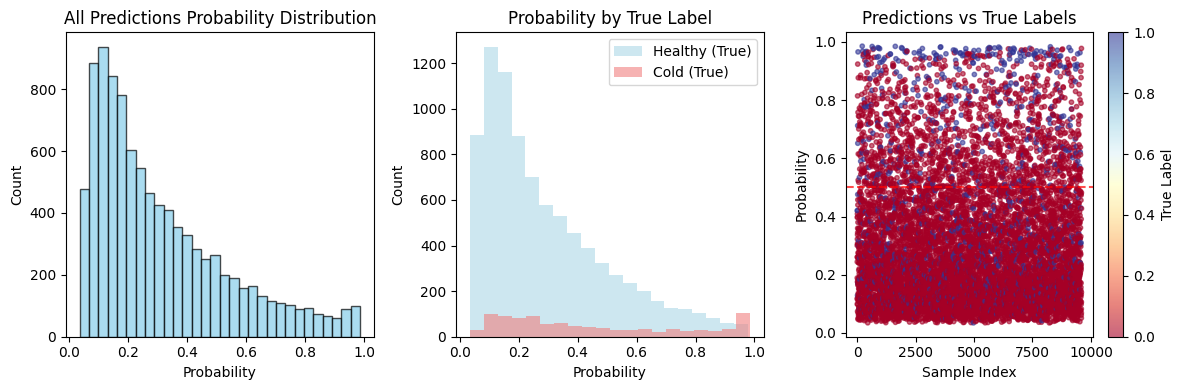


HealthyÊ†∑Êú¨Âπ≥ÂùáÊ¶ÇÁéá: 0.2937
ColdÊ†∑Êú¨Âπ≥ÂùáÊ¶ÇÁéá: 0.4464


In [14]:
import matplotlib.pyplot as plt
import numpy as np

val_probs = np.array(val_probs)
val_labels = np.array(val_labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(val_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('All Predictions Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
healthy_probs = val_probs[val_labels == 0]
cold_probs = val_probs[val_labels == 1]

plt.hist(healthy_probs, bins=20, alpha=0.6, label='Healthy (True)', color='lightblue')
plt.hist(cold_probs, bins=20, alpha=0.6, label='Cold (True)', color='lightcoral')
plt.title('Probability by True Label')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(val_probs)), val_probs, c=val_labels, 
           cmap='RdYlBu', alpha=0.6, s=10)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Predictions vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.colorbar(label='True Label')

plt.tight_layout()
plt.show()

print(f"\nHealthyÊ†∑Êú¨Âπ≥ÂùáÊ¶ÇÁéá: {healthy_probs.mean():.4f}")
print(f"ColdÊ†∑Êú¨Âπ≥ÂùáÊ¶ÇÁéá: {cold_probs.mean():.4f}")

In [15]:
# ÁÑ∂ÂêéÂú®Êñ∞ÁöÑcell‰∏≠Âä†ËΩΩÂíåËØÑ‰º∞ÊúÄ‰Ω≥Ê®°Âûã
from sklearn.metrics import accuracy_score, f1_score, recall_score
from torch.utils.data import DataLoader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ContrastiveEmbeddingExtractor(input_dim=3147, projection_dim=1024, hidden_dim=512).to(device)
model.load_state_dict(torch.load("best_contrastive_fusion_concat.pth"))
model.eval()

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
print("üéØ Evaluating best model on validation set...")

val_preds = []
val_labels = []
val_probs = []
total_val_loss = 0.0

with torch.no_grad():
    for batch_X, batch_y in tqdm(val_loader, desc="Validating best model"):
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        
        logits, projections, features = model(
            batch_X, return_features=True
        )
        
        val_loss, _, _ = criterion(logits, projections, batch_y)
        total_val_loss += val_loss.item()
        
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()
        
        val_probs.extend(probs.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(batch_y.cpu().numpy())

avg_val_loss = total_val_loss / len(val_loader)
val_acc = accuracy_score(val_labels, val_preds)
val_f1 = f1_score(val_labels, val_preds, zero_division=0)
val_uar = recall_score(val_labels, val_preds, average='macro', zero_division=0)

print(f"\nüìä Best Model Performance:")
print(f"   Loss: {avg_val_loss:.4f}")
print(f"   Accuracy: {val_acc:.4f}")
print(f"   F1 Score: {val_f1:.4f}")
print(f"   UAR: {val_uar:.4f}")

if len(set(val_labels)) > 1 and len(set(val_preds)) > 1:
    class_recalls = recall_score(val_labels, val_preds, average=None, zero_division=0)
    print(f"   Class 0 (Healthy) Recall: {class_recalls[0]:.4f}")
    print(f"   Class 1 (Cold) Recall: {class_recalls[1]:.4f}")

üéØ Evaluating best model on validation set...


Validating best model: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [00:04<00:00, 17.49it/s]


üìä Best Model Performance:
   Loss: 0.7283
   Accuracy: 0.7044
   F1 Score: 0.2888
   UAR: 0.6450
   Class 0 (Healthy) Recall: 0.7202
   Class 1 (Cold) Recall: 0.5697
